#######

使用因子分解机（Factorization machines, FM）来获取更丰富的解释性——除了独立特征外，能得到交叉特征（2度）共同作用下对续费率的影响权重。

适用于类别变量，此处使用了续费率中的4个类别标签，visa_typ_cd(9), delta_lable(7), city(22), level(5)来探索；
如果采用FM对续费率继续分析的话，可以将连续变量分桶，转化为类别变量


#######

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from random import normalvariate  # 正态分布
from sklearn.utils import shuffle
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
import time

准备数据

In [2]:
df_data = pd.read_csv('data/all.csv').drop(['Unnamed: 0'], axis=1)
df_data.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,...,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable,city,level
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,...,1.30179,0.604235,1.0,432590.0,down,183,2016,6m,beijin,1st
1,64005,A1,2016-12-24 00:00:00,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,...,2.05988,0.977961,1.0,436223.0,down,182,2017,6m,linfen,4th
2,64005,A1,2017-07-01 00:00:00,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,...,1.44186,0.776597,1.0,434410.0,down,155,2017,6m,beijin,1st


In [3]:
df_features = pd.get_dummies(df_data[['visa_typ_cd', 'delta_lable', 'city', 'level']])
features = np.matrix(df_features)
target = df_data.y.values

In [47]:
df_data.level.value_counts()

2nd     198149
1st     191605
new1     24088
4th       8394
3rd       7735
Name: level, dtype: int64

-------------

# FM算法

传统的LR算法，仅能得到独立的特征权重，FM算法可以计算得到交叉特征的权重。在一些情况中是两个特征共同作用影响y。此处没有引入正则化项

1.学习算法     
目前FM常使用的学习算法有，随机梯度下降（SGD），交替最小二乘法（ALS），马尔科夫蒙特卡洛法（MCMC）。下面使用的是随机梯度下降法。


2.优化函数（损失函数）     
二分类问题使用logit loss，回归问题使用MSE。在续费率问题中，为二分类问题（续费和不续费），loss为log(1+ exp(-y*y_))

In [4]:
def sigmoid(inx):
    return 1.0/(1+np.exp(-inx))

In [5]:
'''初始化交叉项
input:  n(int)特征的个数
        k(int)FM模型的交叉向量维度
output: v(mat):交叉项的系数权重
'''
def initialize_v(n,k):
    v = np.mat(np.zeros((n,k)))

    for i in range(n):
        for j in range(k):
        # 利用正态分布生成每一个权重
            v[i,j] = normalvariate(0,0.2)   # 均值为0，标准差为0.2
    return v

In [6]:
'''得到预测值
input:  dataMatrix(mat)特征
        w(int)常数项权重
        w0(int)一次项权重
        v(float)交叉项权重
output: result(list)预测的结果
'''
def getPrediction(dataMatrix,w0,w,v):
    m = np.shape(dataMatrix)[0]
    result = []
    for i in range(m):
        inter_1 = dataMatrix[i]*v
        inter_2 = np.multiply(dataMatrix[i],dataMatrix[i])*np.multiply(v,v)  # multiply对应元素相乘
        # 完成交叉项
        interaction = np.sum(np.multiply(inter_1,inter_1)-inter_2)/2.0
        p = w0+dataMatrix[i]*w+interaction  # 计算预测的输出 
        pre = sigmoid(p[0,0])
        result.append(pre)
    return result

In [7]:
'''计算预测准确性——二分类问题使用logit loss为作为优化标准
input:  predict(list)预测值
        classLabels(list)标签
output: error(float)计算损失函数的值
'''
def getCost(predict,classLabels):
    m = len(predict)
    error = 0.0
    for i in range(m):
        error -= np.log(sigmoid(predict[i]*classLabels[i]))
    return error

In [8]:
'''计算precision-recall-F1
input: predict(list)预测值
       classLabels(list)标签
output: precison(float)
        recall(float)
        F1(float)
'''
def getMoreMetric(predict, classLabels):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(predict)):
        if (predict[i] > 0.5) & (classLabels[i] == 1.):
            tp = tp + 1
        elif (predict[i] > 0.5) & (classLabels[i] == 0.):
            fp = fp + 1
        elif (predict[i] < 0.5) & (classLabels[i] == 1.):
            fn = fn + 1
    precison = tp / (tp+fp)
    recall = tp / (tp+fn)
    F1 = 2*(precison * recall) / (precison + recall)
    return (precison, recall, F1)

In [9]:
def stocGradAscent(dataMatrix, classLabels, k, max_iter, alpha):
    '''利用随机梯度下降法训练FM模型
    input:  dataMatrix(mat)特征
            classLabels(mat)标签
            k(int)v的维数
            max_iter(int)最大迭代次数
            alpha(float)学习率
    output: w0(float),w(mat),v(mat):权重
    '''
    m, n = np.shape(dataMatrix)
    # 1、初始化参数
    w = np.zeros((n, 1))  # 其中n是特征的个数
    w0 = 0  # 偏置项
    v = initialize_v(n, k)  # 初始化V

    # 2、训练
    for it in xrange(max_iter):
        for x in xrange(m):  # 随机优化，对每一个样本而言的
            inter_1 = dataMatrix[x] * v
            inter_2 = np.multiply(dataMatrix[x],dataMatrix[x]) * np.multiply(v,v)  # multiply对应元素相乘
            # 计算交叉项
            interaction = np.sum(np.multiply(inter_1, inter_1) - inter_2) / 2.
            p = w0 + dataMatrix[x] * w + interaction  # 计算预测的输出
            loss = sigmoid(classLabels[x] * p[0, 0]) - 1
            
            w0 = w0 - alpha * loss * classLabels[x]   # w0更新
            for i in xrange(n):
                if dataMatrix[x, i] != 0:
                    w[i, 0] = w[i, 0] - alpha * loss * classLabels[x] * dataMatrix[x, i]   # wi更新
                    for j in range(k):
                        v[i, j] = v[i, j] - alpha * dataMatrix[x, i] * loss * classLabels[0] * (dataMatrix[x, i]*inter_1[0, j] - v[i, j]*dataMatrix[x, i]*dataMatrix[x, i])   # vij更新

        # 计算损失函数的值
        if it % 10 == 0:
            y_ = getPrediction(dataMatrix, w0, w, v)
            cost = getCost(y_, classLabels)
            accuracy = getAccuracy(y_, classLabels)
            precision, recall, F1 = getMoreMetric(y_, classLabels)
            print("\t------- iter: ", it, 
                  " , cost: ", cost,
                  ", accuracy: ", accuracy,
                  ", precision: ", precision,
                  ", recall: ", recall, 
                  ", F1: ", F1)

    # 3、返回最终的FM模型的参数
    return w0, w, v

In [10]:
'''计算预测准确性
input:  predict(list)预测值
        classLabels(list)标签
output: float(error) / allItem(float)错误率
'''    
def getAccuracy(predict,classLabels):
    m = len(predict)
    allItem = 0
    error = 0
    for i in range(m):
        allItem += 1
        if float(predict[i]) < 0.5 and classLabels[i] == 1.0:
            error += 1
        elif float(predict[i]) >= 0.5 and classLabels[i] == 0.0:
            error += 1
        else:
            continue
    return float(allItem - error)/allItem

In [11]:
'''pre-processign the dataset
'''
df_fm = df_data[['visa_typ_cd', 'delta_lable', 'city', 'level', 'y']]
# shuffle data
df_fm = shuffle(df_fm).reset_index(drop=True)
# split dataset
df_test_features = df_fm.iloc[:120000, :-1]
df_test_target = df_fm.iloc[:120000, -1]
df_train_features = df_fm.iloc[120000:, :-1]
df_train_target = df_fm.iloc[120000:, -1]
# one-hot
df_test_features_oh = pd.get_dummies(df_test_features)
df_train_features_oh = pd.get_dummies(df_train_features)

In [12]:
%time w0, w, v = stocGradAscent(df_train_features_oh.iloc[:500, :].values, df_train_target.iloc[:500].values, 10, 200, 0.01)

('\t------- iter: ', 0, ' , cost: ', 187.42326700007206, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 10, ' , cost: ', 180.1837740051659, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 20, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 30, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 40, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 50, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 60, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', 

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


('\t------- iter: ', 70, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 80, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 90, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 100, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 110, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 120, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.876, ', precision: ', 0.876, ', recall: ', 1.0, ', F1: ', 0.933901918976546)
('\t------- iter: ', 130, ' , cost: ', 180.18374432769957, ', accuracy: ', 0.87

训练速度较慢，此处仅使用了前500条数据，耗时1min5s

w0: 相当于bias       
wi: 相当于各特征的权重         
v: 相当于交叉项的特征权重       

In [13]:
df_weight = pd.DataFrame(w)
df_weight.columns = ['weight']
df_weight.index = df_train_features_oh.columns
df_weight.T

,visa_typ_cd_A,visa_typ_cd_A1,visa_typ_cd_A2,visa_typ_cd_A3,visa_typ_cd_B,visa_typ_cd_C,visa_typ_cd_D1,visa_typ_cd_D2,visa_typ_cd_D3,delta_lable_1m,...,city_wuxi,city_xian,city_yangzhou,city_yantai,city_zhuhai,level_1st,level_2nd,level_3rd,level_4th,level_new1
weight,0.37437,0.0,0.089051,0.0,0.442062,0.102712,0.001258,0.092569,0.0,0.24407,...,0.004074,0.0,0.135627,0.064602,0.057627,0.330973,0.47884,0.145046,0.059253,0.087911


In [53]:
df_weight.sort_values(by='weight', ascending=False).head(6)

,weight
delta_lable_6m,0.635824
level_2nd,0.478840
visa_typ_cd_B,0.442062
visa_typ_cd_A,0.374370
level_1st,0.330973
city_changchun,0.297174


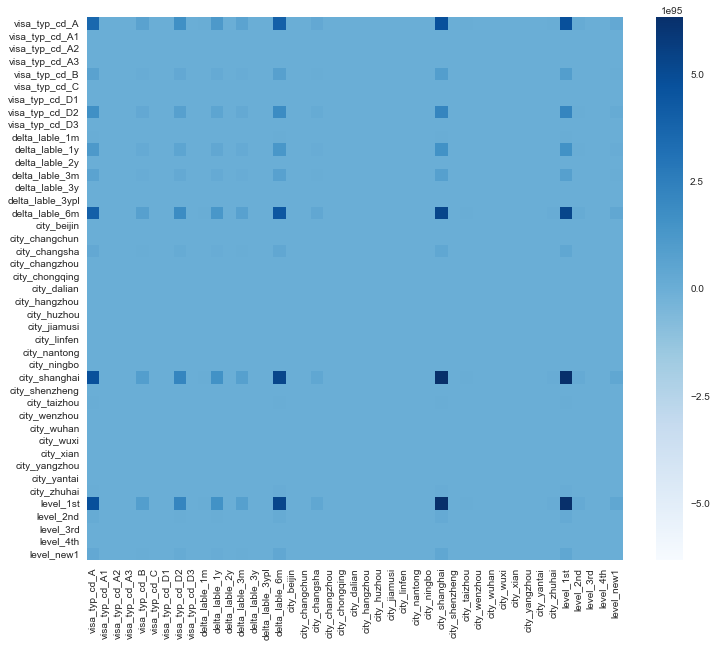

In [15]:
plt.rc('figure', figsize=(12,10))
df_icp = pd.DataFrame(v * v.T)
df_icp.columns = df_weight.index
df_icp.index = df_weight.index
sns.heatmap(df_icp, cmap='Blues')

-----------------------

# tensorflow搭建FM

为了结果与上面的可对比，此处也使用前500条数据

速度上，测试了两种优化器SGD和Adam，耗时分别为0.189s和0.145s，相比自己搭建速度有有大幅提升（1mins5s）

结果上，与手动搭建的FM结果比较相似

In [16]:
import tensorflow as tf

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
# prepare data
n, p = df_train_features_oh[:500].shape
# latent factors
k = 10

# create placeholder
X = tf.placeholder(tf.float32, shape=[None, p])
y = tf.placeholder(tf.float32, shape=[None, 1])

#  weight
w0 = tf.Variable(tf.zeros([1]))
w = tf.Variable(tf.zeros([p]))
v = tf.Variable(tf.random_normal([k,p], stddev=0.01))

# predicition, initialized to 0
y_ = tf.Variable(tf.zeros([n, 1]))

# FM model
linear_term = tf.add(w0, tf.reduce_sum(tf.multiply(w, X), 1, keep_dims=True))
pair_interaction = tf.multiply(0.5, 
                               tf.reduce_sum(
                                   tf.subtract(
                                       tf.pow(tf.matmul(X, tf.transpose(v)), 2),
                                       tf.matmul(tf.pow(X, 2), tf.transpose(tf.pow(v, 2)))),
                                1,keep_dims=True))
y_ = tf.add(linear_term, pair_interaction)

# define loss function:logit loss
loss = tf.log(1+ tf.exp(-y*y_))
# optimizer
optimizer_gd = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
optimizer_adam = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [25]:
with tf.Session() as sess:
    start = time.time()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    w0, w, v, y_, loss, optimizer_ = sess.run([w0, w, v, y_, loss, optimizer_gd], feed_dict={X: df_train_features_oh.iloc[:500].values, y: pd.DataFrame(np.array(df_train_target.iloc[:500], dtype=np.float).reshape(-1,1)).values})
    end = time.time()
    print "total time is: %s" % (end-start)

total time is: 0.189884901047


In [26]:
df_weight_tf = pd.DataFrame(w)
df_weight_tf.columns = ['weight']
df_weight_tf.index = df_train_features_oh.columns
df_weight_tf.T

,visa_typ_cd_A,visa_typ_cd_A1,visa_typ_cd_A2,visa_typ_cd_A3,visa_typ_cd_B,visa_typ_cd_C,visa_typ_cd_D1,visa_typ_cd_D2,visa_typ_cd_D3,delta_lable_1m,...,city_wuxi,city_xian,city_yangzhou,city_yantai,city_zhuhai,level_1st,level_2nd,level_3rd,level_4th,level_new1
weight,0.734812,0.0,0.074981,0.0,1.154782,0.074991,0.004999,0.144962,0.0,0.234959,...,0.009998,0.0,0.049985,0.079974,0.104941,0.860004,1.154588,0.059983,0.044995,0.069956


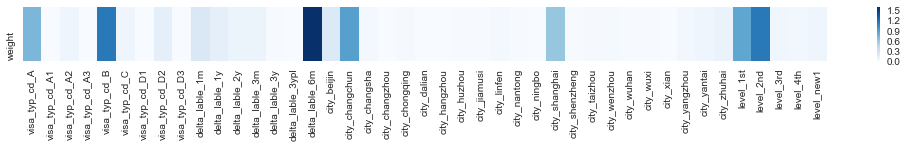

In [27]:
plt.rc('figure', figsize=(18,1))
sns.heatmap(df_weight_tf.T, cmap='Blues')

In [52]:
df_weight_tf.sort_values(by='weight', ascending=False).head(6)

,weight
delta_lable_6m,1.599567
visa_typ_cd_B,1.154782
level_2nd,1.154588
city_changchun,0.899691
level_1st,0.860004
visa_typ_cd_A,0.734812


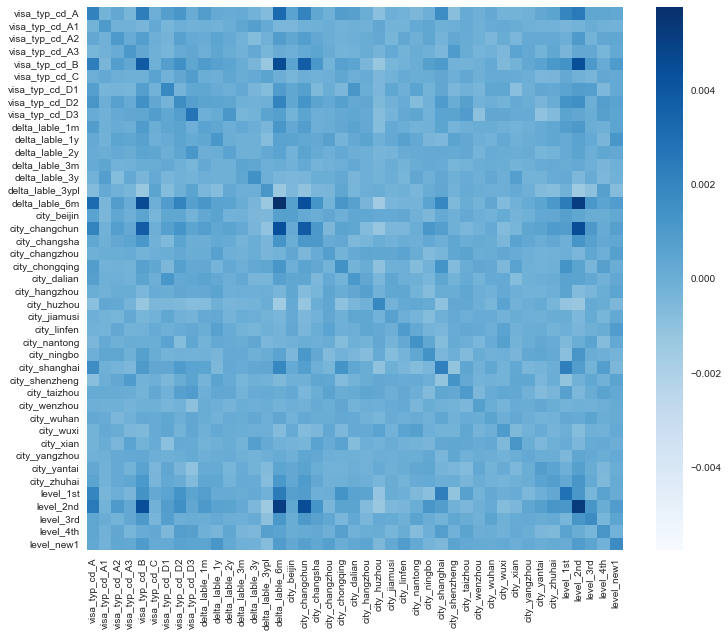

In [31]:
plt.rc('figure', figsize=(12,10))
df_icp_tf = pd.DataFrame(np.matmul(v.T, v))
df_icp_tf.columns = df_weight_tf.index
df_icp_tf.index = df_weight_tf.index
sns.heatmap(df_icp_tf, cmap='Blues')

In [67]:
pd.DataFrame(df_icp_tf.min()).sort_values(by=[0]).head(6)

,0
city_huzhou,-0.001534
delta_lable_6m,-0.001534
level_2nd,-0.001434
delta_lable_3ypl,-0.001434
visa_typ_cd_B,-0.001295
city_changchun,-0.001190


结果：    
A.从独立特征来看，对续费率有比较大影响的因素是：套餐持续时间为6个月，B套餐，二线城市，长春，一线城市，套餐A(手动搭建和tf搭建的结果仅在排序上有略微差别)
 
B.从交叉特征来看，对续费比较有影响的几个交叉因素是
  - 手动搭建：
     - delta_label_6m\*visa_typ_cd_A, 
     - city_shangahi\*visa_typ_cd_A, 
     - level_1st\*visa_typ_cd_A, 
     - level_1st\*delta_label_6m, 
     - delta_label_6m\*city_shanghai, 
     - city_shanghai\*level_1st
  - tf搭建：
     - delta_label_6m\*visa_typ_cd_A, 
     - delta_label_6m\*visa_typ_cd_B, 
     - city_changchun\*visa_typ_cd_A, 
     - city_changchun\*visa_typ_cd_B, 
     - city_changchun\*delta_label_6m, 
     - level_2nd\*visa_typ_cd_B, 
     - level_2nd\*delta_label_6m, 
     - level_2nd\*city_changchun

In [48]:
df_data.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,...,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable,city,level
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,...,1.30179,0.604235,1.0,432590.0,down,183,2016,6m,beijin,1st
1,64005,A1,2016-12-24 00:00:00,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,...,2.05988,0.977961,1.0,436223.0,down,182,2017,6m,linfen,4th
2,64005,A1,2017-07-01 00:00:00,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,...,1.44186,0.776597,1.0,434410.0,down,155,2017,6m,beijin,1st
